# EuroSat Image Classification using DenseNet

Hector Becerra  
Juan Terven  
2023

**DenseNet**, short for Densely Connected Convolutional Network, is an innovative neural network architecture introduced in 2016 by Gao Huang, Zhuang Liu, Laurens van der Maaten, and Kilian Q. Weinberger. It is distinguished by its dense connectivity pattern, where each layer is directly connected to every other layer in a feed-forward fashion. In a DenseNet, the output of each layer is concatenated with the inputs of all subsequent layers, promoting feature reuse and substantially reducing the number of parameters compared to traditional convolutional neural networks (CNNs). This connectivity pattern ensures maximum information flow between layers, making the network more efficient and easier to train. DenseNets have demonstrated exceptional performance in a range of tasks, particularly in image classification, and their architecture has influenced subsequent developments in deep learning models for computer vision.

In [1]:
import os
import numpy as np 
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import wandb
from torch.utils.data import DataLoader
import json
from torchvision.models import densenet161,DenseNet161_Weights

from train_utils import get_predictions,compute_val_loss,EarlyStopping,train_model
from eval_utils import remove_wandb_hooks,evaluate_test_set,precision_recall_analysis
from EuroSAT import EurosatDataset,visualize_classes


In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")  
    print("Found GPU")
else:
    torch.device("cpu")
    
print("Pytorch version:", torch.__version__)

Found GPU
Pytorch version: 1.13.1+cu117


## Login to Wandb to log experiment

In [3]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'EuroSat_DenseNet_Classifier.ipynb'

wandb.login()

wandb: Currently logged in as: jrterven. Use `wandb login --relogin` to force relogin


True

# Data
The [EuroSat Dataset](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8736785) consists of 27,000 labeled images with ten different land use and land cover classes. It is multi-spectral, covering 13 spectral bands in the visible, near infrared, and short wave infrared parts of the spectrum. The dataset is geo-referenced and based on openly and freely accessible earth observation data. The classes are the following.

| No. | Land Use Type           |
|-----|-------------------------|
| 1   | AnnualCrop              |
| 2   | Forest                  |
| 3   | HerbaceousVegatation    |
| 4   | Highway                 |
| 5   | Industrial              |
| 6   | Pasture                 |
| 7   | PermanentCrop           |
| 8   | Residential             |
| 9   | River                   |
| 10  | SeaLake                 |

In [3]:
data_path = "C:/Users/jrtervens/Documents/data/eurosat/EuroSAT/"

In [4]:
# Load the labels 
f = open(f"{data_path}label_map.json", "r")
label_to_index = json.load(f)

In [5]:
index_to_label = {label_to_index[k]:k for k in label_to_index}
print(index_to_label)

{0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}


## Data Transformations

In [6]:
# Check the transformations used in the pre-trained model
weights = DenseNet161_Weights.DEFAULT
preprocess = weights.transforms()
print(preprocess)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [7]:
# Define a sequence of transformations to be applied to images
transformToTensor = transforms.Compose([
    # Resize the image to have a minimum size of 64 pixels along the shortest dimension,
    # preserving the aspect ratio of the original image.
    transforms.Resize((64,)),

    # Crop the image at the center to get a 64x64 square.
    transforms.CenterCrop((64, 64)),

    # Convert the image to a PyTorch tensor.
    transforms.ToTensor(),

    # Normalize the tensor image with mean and standard deviation for each color channel.
    # These specific values are generally used for pre-trained models.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
# Create dataset instances
# Instantiate the EurosatDataset class for training data.
train_dataset = EurosatDataset(_type='train', transform=transformToTensor,
                               data_path=data_path)

# Instantiate the EurosatDataset class for validation data.
valid_dataset = EurosatDataset(_type="valid", transform=transformToTensor,
                               data_path=data_path)

# Instantiate the EurosatDataset class for testing data.
test_dataset = EurosatDataset(_type="test", transform=transformToTensor,
                              data_path=data_path)

# Define batch sizes for training and validation data.
train_batch = 64  # The batch size for training data.
val_batch = 16     # The batch size for validation data.

# Create DataLoaders
# Create a DataLoader for the training dataset. This DataLoader will automatically
# group the training data into batches of size 128 and shuffle them in each epoch.
train_loader = DataLoader(train_dataset, batch_size=train_batch, shuffle=True)

# Create a DataLoader for the validation dataset. This DataLoader groups the validation
# data into batches of size 32. The data is not shuffled, which is typical for validation data.
valid_loader = DataLoader(valid_dataset, batch_size=val_batch, shuffle=False)

# Create a DataLoader for the testing dataset. This DataLoader processes the test data
# one sample at a time (batch size of 1) and does not shuffle the data. This is typical
# for test data since we often want to evaluate the model on test data in a specific order.
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

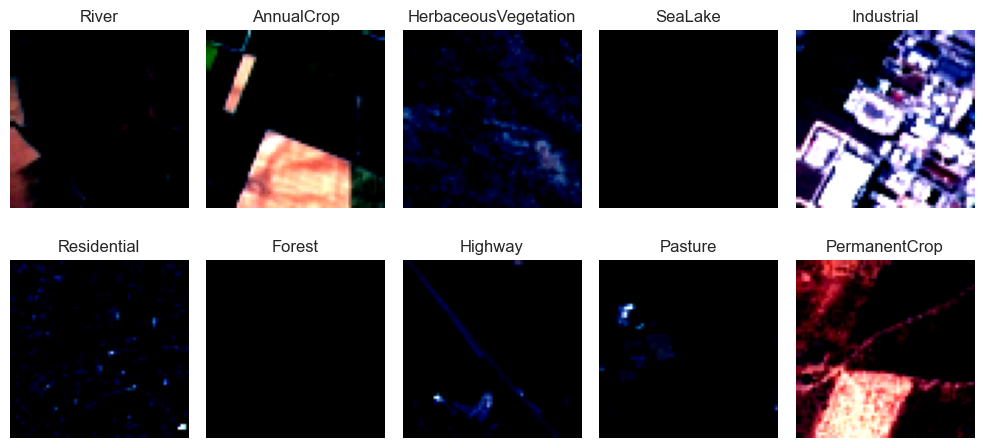

In [9]:
visualize_classes(train_loader, index_to_label)

In [10]:
dataset_managers = {
    'valid': valid_loader,
    'train': train_loader,
    'test': test_loader
}

print(f"Train set batches: {len(train_loader)}")
print(f"Validation set batches: {len(valid_loader)}")
print(f"Test set examples: {len(test_loader)}")

Train set batches: 296
Validation set batches: 338
Test set examples: 2700


## Labels distribution

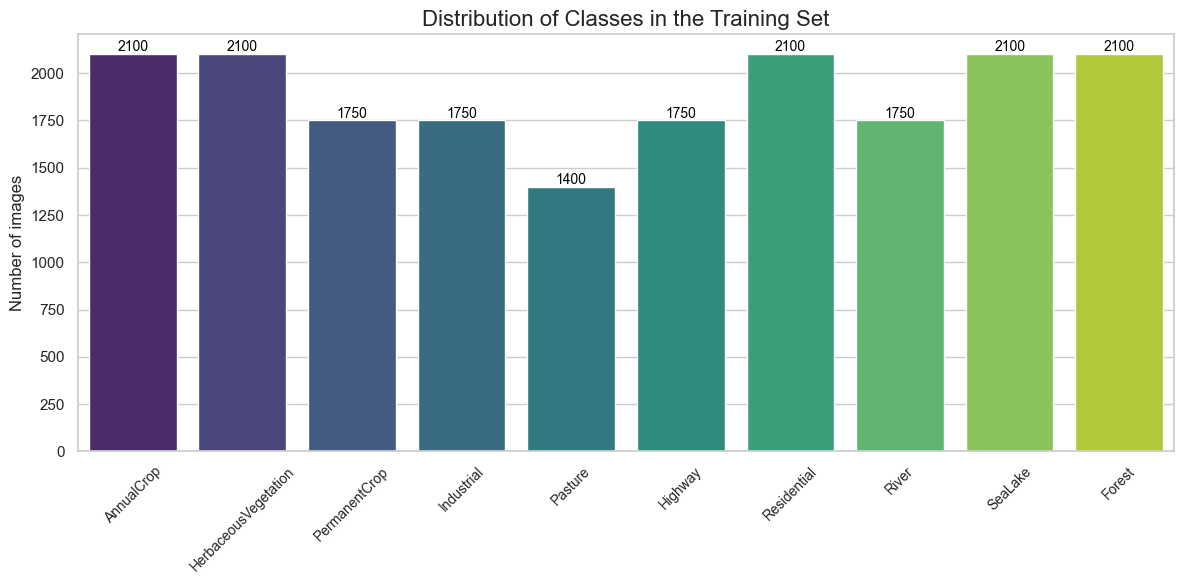

In [11]:
labels = train_dataset.data['Label'].values  # Assuming 'Label' is the column with labels

# Convert numerical labels to string names if necessary
label_names = [index_to_label[label] for label in labels]

sns.set(style="whitegrid")  # Set style
plt.figure(figsize=(12, 6))

# Adjusted according to the new API
ax = sns.countplot(x=label_names, hue=label_names, palette="viridis", legend=False)

#plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of images', fontsize=12)
plt.title('Distribution of Classes in the Training Set', fontsize=16)
plt.xticks(rotation=45, fontsize=10)

# Add the count above the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()



# Model

In [12]:
# Use un-pretrained model
model = densenet161()

# Replace the model head with the number of classes
num_classes = 10
model.classifier = nn.Linear(2208, num_classes) 
model.to(DEVICE)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

# Training model from Scratch

In [15]:
project_name = "EuroSAT"
model_name = "DenseNet"
models_path = "C:/Users/jrtervens/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models/"

In [16]:
epochs = 200
lr = 0.0001
patience = 10

run = wandb.init(
    # Set the project where this run will be logged
    project=project_name,
    name=model_name,
    notes="DenseNet from scratch",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": train_batch,
        "patience": patience
    })

loss_i, loss_val_i = train_model(model=model, epochs=epochs, 
                                 train_loader=train_loader,
                                 valid_loader=valid_loader,
                                 lr=lr, patience=patience, device=DEVICE)

Starting training with early stopping patience of 10
Each epoch has 296 steps.

Epoch: 1...
Step: 21/296 Loss: 1.6594304084777831
Step: 41/296 Loss: 1.0669396251440049
Step: 61/296 Loss: 0.8791992425918579
Step: 81/296 Loss: 0.8357467532157898
Step: 101/296 Loss: 0.7821768462657929
Step: 121/296 Loss: 0.7444588392972946
Step: 141/296 Loss: 0.7688374638557434
Step: 161/296 Loss: 0.6793452933430671
Step: 181/296 Loss: 0.680398841202259
Step: 201/296 Loss: 0.7593987554311752
Step: 221/296 Loss: 0.7266821950674057
Step: 241/296 Loss: 0.6470333591103554
Step: 261/296 Loss: 0.632297633588314
Step: 281/296 Loss: 0.6147580116987228
Validation Loss: 0.8281 Accuracy: 0.7331
Epoch duration: 80.81s

Epoch: 2...
Step: 21/296 Loss: 0.763904744386673
Step: 41/296 Loss: 0.7317589357495308
Step: 61/296 Loss: 0.6851633921265602
Step: 81/296 Loss: 0.5972379744052887
Step: 101/296 Loss: 0.6009503722190856
Step: 121/296 Loss: 0.5301300689578057
Step: 141/296 Loss: 0.5564617723226547
Step: 161/296 Loss: 0.5

Step: 21/296 Loss: 0.14485734794288874
Step: 41/296 Loss: 0.11687742453068495
Step: 61/296 Loss: 0.11551760779693723
Step: 81/296 Loss: 0.12683564964681865
Step: 101/296 Loss: 0.10820765299722553
Step: 121/296 Loss: 0.18831887245178222
Step: 141/296 Loss: 0.1309867871925235
Step: 161/296 Loss: 0.11006672824732959
Step: 181/296 Loss: 0.11225394066423178
Step: 201/296 Loss: 0.10039242058992386
Step: 221/296 Loss: 0.09914362085983157
Step: 241/296 Loss: 0.13033499494194983
Step: 261/296 Loss: 0.1433623580262065
Step: 281/296 Loss: 0.16305739842355252
Validation Loss: 0.3270 Accuracy: 0.9026
Epoch duration: 71.83s

Epoch: 15...
Step: 21/296 Loss: 0.13322262950241565
Step: 41/296 Loss: 0.10576347634196281
Step: 61/296 Loss: 0.12033415548503398
Step: 81/296 Loss: 0.08488733135163784
Step: 101/296 Loss: 0.1252728147432208
Step: 121/296 Loss: 0.13792218528687955
Step: 141/296 Loss: 0.0807339383289218
Step: 161/296 Loss: 0.08241371857002378
Step: 181/296 Loss: 0.09385535903275014
Step: 201/296 

Step: 21/296 Loss: 0.07632851512171328
Step: 41/296 Loss: 0.06266652077902109
Step: 61/296 Loss: 0.05482676792889833
Step: 81/296 Loss: 0.044431113498285414
Step: 101/296 Loss: 0.06422414181288331
Step: 121/296 Loss: 0.03097659177146852
Step: 141/296 Loss: 0.08165447118226439
Step: 161/296 Loss: 0.05700368215329945
Step: 181/296 Loss: 0.0439601190853864
Step: 201/296 Loss: 0.01761260909261182
Step: 221/296 Loss: 0.028434671877766958
Step: 241/296 Loss: 0.02311492500593886
Step: 261/296 Loss: 0.015933067922014744
Step: 281/296 Loss: 0.032884627534076574
Validation Loss: 0.8312 Accuracy: 0.8204
Epoch duration: 67.95s

Epoch: 28...
Step: 21/296 Loss: 0.1860320745036006
Step: 41/296 Loss: 0.07551895240321756
Step: 61/296 Loss: 0.037608986534178254
Step: 81/296 Loss: 0.037247572047635916
Step: 101/296 Loss: 0.04000658211298287
Step: 121/296 Loss: 0.03406486334861256
Step: 141/296 Loss: 0.041242981399409476
Step: 161/296 Loss: 0.03773292484693229
Step: 181/296 Loss: 0.034044430090580134
Step

Validation Loss: 0.3472 Accuracy: 0.9126
Epoch duration: 68.67s

Epoch: 40...
Step: 21/296 Loss: 0.041144404327496886
Step: 41/296 Loss: 0.023217144096270202
Step: 61/296 Loss: 0.03480999566381797
Step: 81/296 Loss: 0.029496940528042616
Step: 101/296 Loss: 0.0338467595516704
Step: 121/296 Loss: 0.04979111016727984
Step: 141/296 Loss: 0.04554328043013811
Step: 161/296 Loss: 0.042022750386968254
Step: 181/296 Loss: 0.05134202262852341
Step: 201/296 Loss: 0.08302480434067547
Step: 221/296 Loss: 0.04268736927770078
Step: 241/296 Loss: 0.06467118714936078
Step: 261/296 Loss: 0.0511256798170507
Step: 281/296 Loss: 0.03437256100587547
Validation Loss: 0.4157 Accuracy: 0.9056
Epoch duration: 67.02s

Epoch: 41...
Step: 21/296 Loss: 0.08780105055775493
Step: 41/296 Loss: 0.037624888285063204
Step: 61/296 Loss: 0.01956923811812885
Step: 81/296 Loss: 0.015642118058167398
Step: 101/296 Loss: 0.01911675659939647
Step: 121/296 Loss: 0.012414307307335549
Step: 141/296 Loss: 0.010964524642622564
Step: 

Step: 241/296 Loss: 0.01372095211991109
Step: 261/296 Loss: 0.01827299202559516
Step: 281/296 Loss: 0.025849350163480268
Validation Loss: 0.3846 Accuracy: 0.9143
Epoch duration: 68.80s

Epoch: 53...
Step: 21/296 Loss: 0.055168757442152126
Step: 41/296 Loss: 0.0389280948555097
Step: 61/296 Loss: 0.03546728864312172
Step: 81/296 Loss: 0.01992900330806151
Step: 101/296 Loss: 0.016491969392518513
Step: 121/296 Loss: 0.010689840614213608
Step: 141/296 Loss: 0.0134534852928482
Step: 161/296 Loss: 0.02657152581959963
Step: 181/296 Loss: 0.024189882731297983
Step: 201/296 Loss: 0.02442944535287097
Step: 221/296 Loss: 0.021283311070874333
Step: 241/296 Loss: 0.01465635618660599
Step: 261/296 Loss: 0.04003511934715789
Step: 281/296 Loss: 0.02463107401272282
Validation Loss: 0.4175 Accuracy: 0.9139
Epoch duration: 65.64s

Epoch: 54...
Step: 21/296 Loss: 0.0658082309179008
Step: 41/296 Loss: 0.04141361567890271
Step: 61/296 Loss: 0.03979278610786423
Step: 81/296 Loss: 0.012154942459892482
Step: 10

Step: 181/296 Loss: 0.005911663921142463
Step: 201/296 Loss: 0.008658267112332396
Step: 221/296 Loss: 0.004360443009500159
Step: 241/296 Loss: 0.011735369245434413
Step: 261/296 Loss: 0.021165571257006376
Step: 281/296 Loss: 0.021973212053853785
Validation Loss: 0.3992 Accuracy: 0.9120
Epoch duration: 134.73s

Early stopping invoked in epoch 65


## Save model

In [17]:
# Create models directory
os.makedirs(models_path, exist_ok=True)

# 2. Create model save path
model_save_path = os.path.join(models_path, model_name + ".pth")

# 3. Save the model state dict
print(f"Saving model to: {model_save_path}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=model_save_path)

Saving model to: C:/Users/jrtervens/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models\EuroSAT-DenseNet.pth


In [18]:
# Save the loss data in a file
with open(f"{models_path}/loss_{model_name}.txt", "w") as file:
    file.write(f"loss_i: {loss_i}\n")
    file.write(f"loss_val_i: {loss_val_i}\n")

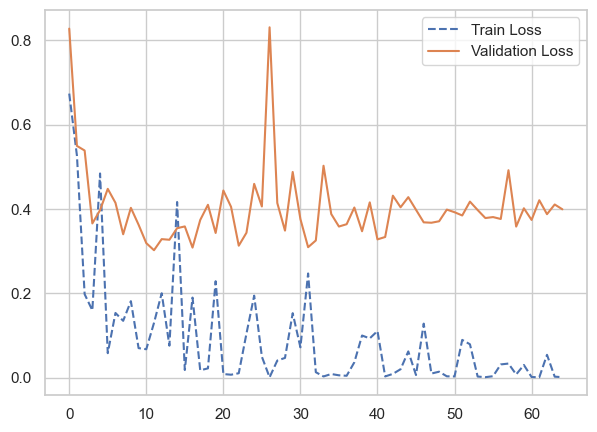

In [19]:
plt.figure(figsize=(7,5))
# Use a dashed line for the training loss, and add markers
plt.plot(loss_i, label="Train Loss", linestyle='--', alpha=1.0)

# Use a solid line for the validation loss
plt.plot(loss_val_i, label="Validation Loss", linestyle='-', alpha=1.0)
plt.legend()
plt.show()

# Evaluate model

In [20]:
# Call this function before evaluating your model to remove any wandb hook
#remove_wandb_hooks(model)

## Load trained model

In [16]:
# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
model_save_path = models_path + f"{model_name}.pth"
print(f"Loading model {model_save_path}")
model.load_state_dict(torch.load(f = model_save_path))

Loading model C:/Users/jrtervens/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models/DenseNet.pth


<All keys matched successfully>

In [17]:
evaluate_test_set(model, test_loader, DEVICE, index_to_label=index_to_label)

                      precision    recall  f1-score   support

          AnnualCrop      0.912     0.937     0.924       300
              Forest      0.957     0.973     0.965       300
HerbaceousVegetation      0.868     0.920     0.893       300
             Highway      0.920     0.824     0.869       250
          Industrial      0.913     0.964     0.938       250
             Pasture      0.914     0.905     0.910       200
       PermanentCrop      0.910     0.808     0.856       250
         Residential      0.980     0.967     0.973       300
               River      0.895     0.920     0.907       250
             SeaLake      0.968     0.993     0.980       300

            accuracy                          0.925      2700
           macro avg      0.924     0.921     0.922      2700
        weighted avg      0.925     0.925     0.924      2700



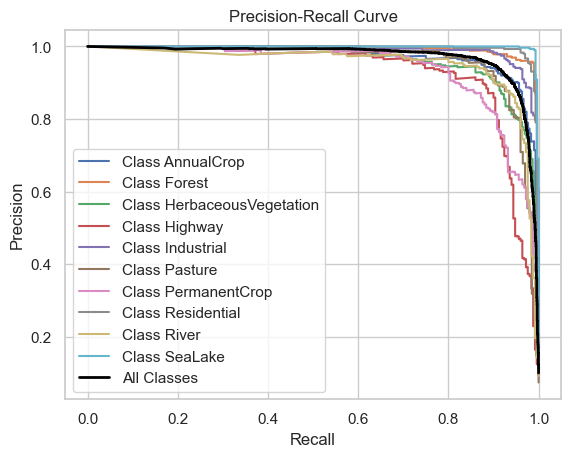

In [22]:
precision_recall_analysis(model, test_loader, DEVICE,
                          output_path=models_path,
                          model_name=model_name,
                          index_to_label=index_to_label)

In [23]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▁▂▁▂▂▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▆▅▅▆▆▇▇▇▇▇▇▇▇▆▄▇▇██▇█▇▇█▇▇▇█▇▇▇██▇▇█▇▇
val_loss,█▄▂▂▂▂▂▁▁▂▁▂▂▂▁▃█▂▃▁▁▂▂▂▃▁▃▃▂▂▂▂▃▂▂▄▂▂▂▂
epoch,64
step,19224
train_loss,0.02197
val_accuracy,0.91204
val_loss,0.3992


## Load the precision/recall curve and plot it

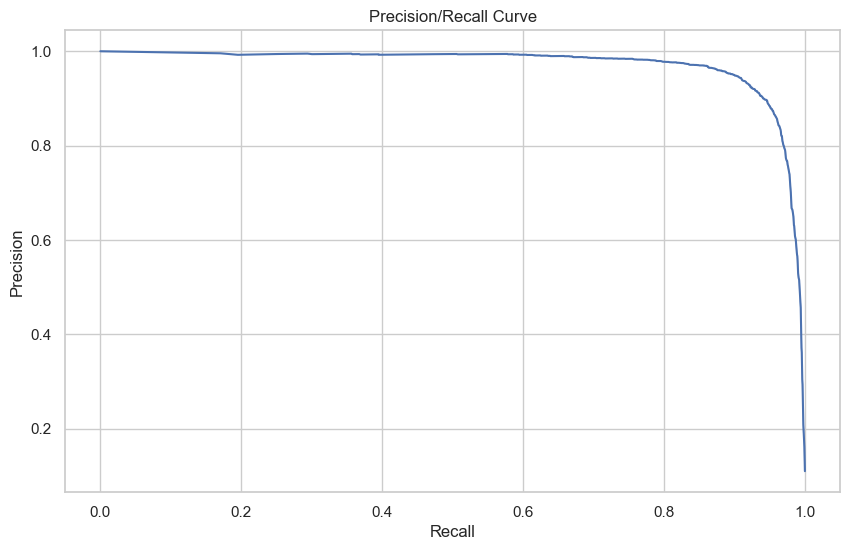

In [24]:
filename = f"{model_name}_precision_recall_values.json"
file_path = os.path.join(models_path, filename)

with open(file_path, 'r') as file:
    precision_recall_data = json.load(file)
    
all_classes_data = precision_recall_data['All Classes']

# Extract precision and recall values
precisions = all_classes_data.get('precision', [])
recalls = all_classes_data.get('recall', [])

# Create a DataFrame for plotting
df = pd.DataFrame({
    'Precision': precisions,
    'Recall': recalls
})

# Plotting the precision/recall curve
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Recall', y='Precision')
plt.title('Precision/Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

## Clean-up

In [18]:
import gc

del model
torch.cuda.empty_cache()
gc.collect()


26288

# Now train the model with pre-trained weights

In [19]:
# Use pretrained model
model2 = densenet161(weights=DenseNet161_Weights.IMAGENET1K_V1)

# Replace the model head with the number of classes
num_classes = 10
model2.classifier = nn.Linear(2208, num_classes) 
model2.to(DEVICE)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

## Train

In [20]:
model_name = "DenseNet-Pretrained"

In [28]:
epochs = 200
lr = 0.0001
patience = 10

run = wandb.init(
    # Set the project where this run will be logged
    project=project_name,
    name=model_name,
    notes="DenseNet pre-trained on ImageNet",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": train_batch,
        "patience": patience
    })

loss_i, loss_val_i = train_model(model=model2, epochs=epochs, 
                                 train_loader=train_loader,
                                 valid_loader=valid_loader,
                                 lr=lr, patience=patience, device=DEVICE)

Starting training with early stopping patience of 10
Each epoch has 296 steps.

Epoch: 1...
Step: 21/296 Loss: 1.427887749671936
Step: 41/296 Loss: 0.4595629870891571
Step: 61/296 Loss: 0.25171497613191607
Step: 81/296 Loss: 0.21491496674716473
Step: 101/296 Loss: 0.16805666945874692
Step: 121/296 Loss: 0.16217294260859488
Step: 141/296 Loss: 0.1741508487612009
Step: 161/296 Loss: 0.13298418670892714
Step: 181/296 Loss: 0.1422012781724334
Step: 201/296 Loss: 0.15117146596312522
Step: 221/296 Loss: 0.12254679407924414
Step: 241/296 Loss: 0.12894207052886486
Step: 261/296 Loss: 0.1383128484711051
Step: 281/296 Loss: 0.12010727040469646
Validation Loss: 0.0870 Accuracy: 0.9739
Epoch duration: 125.97s

Epoch: 2...
Step: 21/296 Loss: 0.27658997057005763
Step: 41/296 Loss: 0.2402962628751993
Step: 61/296 Loss: 0.24493946153670548
Step: 81/296 Loss: 0.17891337126493453
Step: 101/296 Loss: 0.1868835262954235
Step: 121/296 Loss: 0.13591056764125825
Step: 141/296 Loss: 0.12291134651750327
Step: 

## Save model

In [29]:
# Create models directory
os.makedirs(models_path, exist_ok=True)

# 2. Create model save path
model_save_path = os.path.join(models_path, model_name + ".pth")

# 3. Save the model state dict
print(f"Saving model to: {model_save_path}")
torch.save(obj=model2.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=model_save_path)

Saving model to: C:/Users/jrtervens/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models\EuroSAT-DenseNet-Pretrained.pth


In [30]:
# Save the loss data in a file
with open(f"{models_path}/loss_{model_name}.txt", "w") as archivo:
    archivo.write(f"loss_i: {loss_i}\n")
    archivo.write(f"loss_val_i: {loss_val_i}\n")

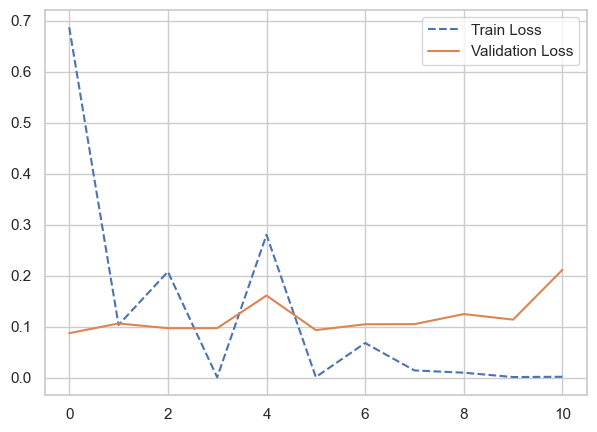

In [31]:
plt.figure(figsize=(7,5))
# Use a dashed line for the training loss, and add markers
plt.plot(loss_i, label="Train Loss", linestyle='--', alpha=1.0)

# Use a solid line for the validation loss
plt.plot(loss_val_i, label="Validation Loss", linestyle='-', alpha=1.0)
plt.legend()
plt.show()

# Evaluate model

In [32]:
# Call this function before evaluating your model to remove any wandb hook
#remove_wandb_hooks(model)

## Load trained model

In [21]:
# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
model_save_path = models_path + f"{model_name}.pth"
print(f"Loading model {model_save_path}")
model2.load_state_dict(torch.load(f = model_save_path))

Loading model C:/Users/jrtervens/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models/DenseNet-Pretrained.pth


<All keys matched successfully>

In [22]:
evaluate_test_set(model2, test_loader, DEVICE, index_to_label=index_to_label)

                      precision    recall  f1-score   support

          AnnualCrop      0.976     0.950     0.963       300
              Forest      0.984     0.997     0.990       300
HerbaceousVegetation      0.778     0.983     0.869       300
             Highway      0.968     0.976     0.972       250
          Industrial      0.992     0.956     0.974       250
             Pasture      0.970     0.955     0.962       200
       PermanentCrop      0.983     0.696     0.815       250
         Residential      0.962     1.000     0.980       300
               River      0.992     0.944     0.967       250
             SeaLake      0.974     1.000     0.987       300

            accuracy                          0.949      2700
           macro avg      0.958     0.946     0.948      2700
        weighted avg      0.955     0.949     0.949      2700



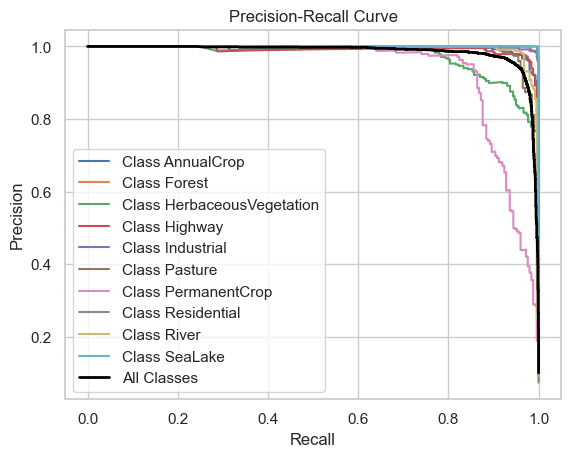

In [34]:
precision_recall_analysis(model2, test_loader, DEVICE,
                          output_path=models_path,
                          model_name=model_name,
                          index_to_label=index_to_label)

In [35]:
wandb.finish()

epoch,▁▂▂▃▄▅▅▆▇▇█
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▄▃▃▅▃▃▃▁▂▂▂▁▂▂▂▂▂▂▁▃▁▁▁▁▁▁▂▂▁▁▂▂▁▁▂▁▁▁▁
val_accuracy,█▄▇▇▂▇▇▇▆█▁
val_loss,▁▂▂▂▅▁▂▂▃▃█
epoch,10
step,3240
train_loss,0.03469
val_accuracy,0.94667
val_loss,0.21124


In [23]:
del model2
torch.cuda.empty_cache()
gc.collect()

9